## Portfolio optimization using a ClassicalGAN

### Defining some utility functions for generating random noise and obtaining a Multivariate Normal distribution from the seed dataset

In [ ]:
import torch
from torch.distributions.multivariate_normal import MultivariateNormal

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def multiDistribution(data_seed):
    mean = torch.mean(data_seed, axis=0)
    covariance = torch.cov(torch.permute(data_seed, (1, 0)))
    # To ensure that the covariance matrix is positive definite
    epsilon = 1e-6  # We add a mall value to add to diagonal
    covariance += epsilon * torch.eye(covariance.size(0), device=covariance.device)
    distribution = MultivariateNormal(loc=mean, covariance_matrix=covariance)
    return distribution

def generate_random_noise(batch_size, sample_dim): #  we use batch size 256 and sample_dim 5
    return torch.randn(batch_size, sample_dim).to(device)


### Loading the portfolio prices dataset to obtain the mean and covariance

In [ ]:
import torch
import pandas as pd
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'

prices = pd.read_csv("./data/prices.csv", index_col=0)

prices = prices.iloc[:, :5] # we use only the first 5 assets
assets = list(prices.columns) # the assets in the portfolio

mean = torch.Tensor(np.array(prices.pct_change().mean() * 252)).to(device)
covariance = torch.Tensor(np.array(prices.pct_change().cov() * 252)).to(device)
# pct_change() computes the percentage change between the current and a prior element

### Defining the Generator and Discriminator models 

In [ ]:
import torch
import numpy as np
from qiskit_algorithms.utils import algorithm_globals
from scipy.stats import norm
from qiskit import QuantumCircuit
from qiskit.circuit.library import EfficientSU2
from torch import nn
from qiskit.primitives import Sampler
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.neural_networks import SamplerQNN
from torch.optim import Adam
from tqdm import tqdm

class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)


class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

### Defining the objective function

In [ ]:
def objective(portfolio_allocations):
    lambda_ = 0.5 # return-risk trade-off parameter

    total_objective = []
    for portfolio in portfolio_allocations:
        global mean, covariance # the mean and covariance matrix of the returns of the assets
        
        risk = 0
        for i in range(portfolio_allocations.shape[1]): # for each asset
            for j in range(portfolio_allocations.shape[1]): # for each asset
                risk += covariance[i][j] * portfolio[i] * portfolio[j] # calculate the risk of the portfolio

        returns = 0
        for i in range(portfolio_allocations.shape[1]): # for each asset
            returns = returns + mean[i] * portfolio[i] # calculate the return of the portfolio

        sum = 0 
        for i in range(portfolio_allocations.shape[1]): 
            sum += portfolio[i]

        objective_value = lambda_ * risk - (1 - lambda_) * returns

        total_objective.append(objective_value)

    return torch.Tensor(total_objective).to(device)

### Optimization using the ClassicalGAN

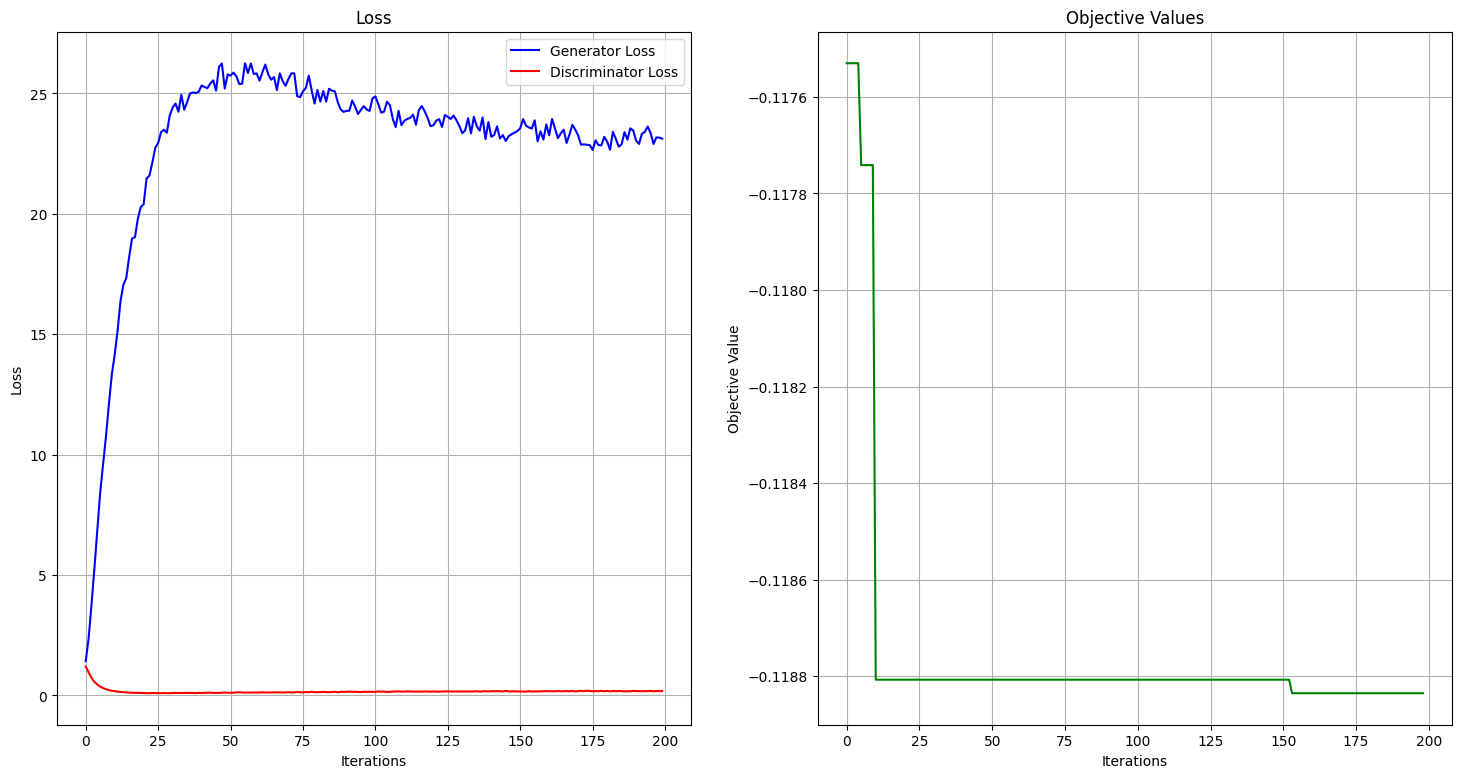

22.8 :: 0.16 :: -0.11883534491062164 :: (573.8868408203125, 41566.9609375): 100%|██████████| 200/200 [20:17<00:00,  6.09s/it]


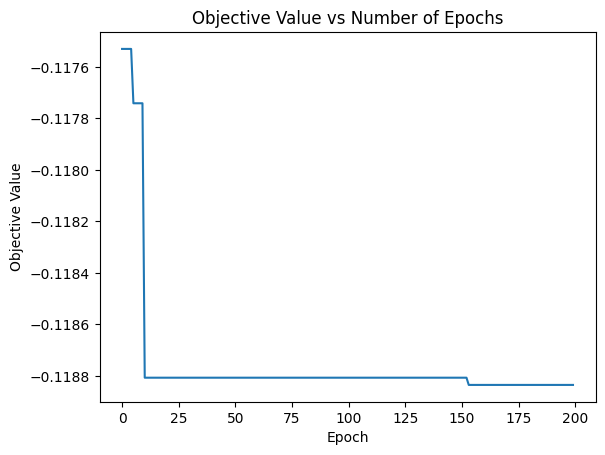

In [ ]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output

class ClassicalGAN:
    def __init__(self, sample_dim, batch_size, num_epochs, learning_rate, initial_seed_path="./data/initial_seed.csv"):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.sample_dim = sample_dim
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.learning_rate = learning_rate
        
        # Load initial seed data
        self.initial_seed = torch.from_numpy(np.array(pd.read_csv(initial_seed_path, index_col=0))).to(self.device)
        
        # Initialize the Generator and Discriminator
        self.generator = Generator(sample_dim, sample_dim).to(self.device)
        self.discriminator = Discriminator(sample_dim).to(self.device)

        # Loss function and optimizers
        self.criterion = nn.BCELoss()  # Binary Cross Entropy Loss
        self.generator_optimizer = optim.Adam(self.generator.parameters(), lr=learning_rate)
        self.discriminator_optimizer = optim.Adam(self.discriminator.parameters(), lr=learning_rate)
        
        self.distri = multiDistribution(self.initial_seed) # Distribution of the initial seed
        
        # Placeholder for cost values and losses
        self.new_samples = np.array([])
        self.initial_seed_cost = objective(self.initial_seed)
        self.ground_val = self.initial_seed_cost.min().item()

        # Initialize lists to store the values for plotting
        self.cost_values = []
        self.generator_loss_values = []
        self.discriminator_loss_values = []
        self.avg_generator_loss_values = []
        self.avg_discriminator_loss_values = []

    def plot_training_progress(self):
        if len(self.generator_loss_values) < 2:
            return

        clear_output(wait=True)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))

        # Plot Generator and Discriminator Loss
        ax1.set_title("Loss")
        ax1.plot(self.avg_generator_loss_values, label="Generator Loss", color="blue")
        ax1.plot(self.avg_discriminator_loss_values, label="Discriminator Loss", color="red")
        ax1.legend(loc='best')
        ax1.set_xlabel("Iterations")
        ax1.set_ylabel("Loss")
        ax1.grid()

        # Plot Objective Values
        ax2.set_title("Objective Values")
        ax2.plot(self.cost_values, label="Objective Value", color="green")
        ax2.set_xlabel("Iterations")
        ax2.set_ylabel("Objective Value")
        ax2.grid()

        plt.show()
        plt.close()

    def train_discriminator(self, real_samples, fake_samples):
        self.discriminator.zero_grad()
        
        real_labels = torch.ones(self.batch_size, 1).to(self.device)
        fake_labels = torch.zeros(self.batch_size, 1).to(self.device)
        
        d_real_output = self.discriminator(real_samples)
        d_real_loss = self.criterion(d_real_output, real_labels)

        d_fake_output = self.discriminator(fake_samples)
        d_fake_loss = self.criterion(d_fake_output, fake_labels)

        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        self.discriminator_optimizer.step()
        
        return d_loss.item()

    def train_generator(self, fake_samples):
        self.generator.zero_grad()
        
        real_labels = torch.ones(self.batch_size, 1).to(self.device)
        g_fake_output = self.discriminator(fake_samples)
        g_loss = self.criterion(g_fake_output, real_labels)
        g_loss.backward()
        self.generator_optimizer.step()
        
        return g_loss.item()

    def generate_new_samples(self):
        return self.generator(generate_random_noise(1000, 5)).detach()

    def update_seed(self):
        # Update the seed with the new samples
        # We only update the seed if there are new samples, selecting the top 5000 samples in each iteration
        if self.new_samples.any():
            self.initial_seed = torch.cat((self.initial_seed, self.new_samples), dim=0)
            self.initial_seed_cost = objective(self.initial_seed)
            sort_ind = torch.sort(self.initial_seed_cost, dim=0)[1]
            self.initial_seed = self.initial_seed[sort_ind]
            self.initial_seed = self.initial_seed[:5000]
            self.ground_val = self.initial_seed_cost.min().item()
            self.distri = multiDistribution(self.initial_seed)
            self.new_samples = np.array([])

    def train(self):
        pbar = tqdm(range(self.num_epochs))  # Progress bar for visualization
        
        for epoch in pbar:
            self.update_seed()

            # update the mean and std of the initial seed
            mean, std = torch.mean(self.initial_seed_cost), torch.std(self.initial_seed_cost)

            for batch_idx in range(10000 // self.batch_size):  # We use batch size 256
                # Sample real and fake data
                real_samples = self.distri.sample(sample_shape=[self.batch_size]).to(self.device).float()
                real_samples /= real_samples.sum(dim=1, keepdim=True)

                fake_samples = self.generate_new_samples()  # Generate fake samples matching batch size
                fake_samples = fake_samples[:self.batch_size]  # Ensure batch size is correct
                fake_samples /= fake_samples.sum(dim=1, keepdim=True)

                # Train Discriminator
                d_loss = self.train_discriminator(real_samples, fake_samples)
                self.discriminator_loss_values.append(d_loss)

                # Train Generator
                g_loss = self.train_generator(fake_samples)
                self.generator_loss_values.append(g_loss)

            # Generate new samples and reset
            self.new_samples = self.generate_new_samples()
            self.new_samples = self.new_samples[:self.batch_size] 
            self.new_samples /= self.new_samples.sum(dim=1, keepdim=True)
            
            pbar.set_description(f"{round(g_loss,2)} :: {round(d_loss,2)} :: {self.ground_val} :: {mean.item(), std.item()}")

            avg_gen_loss = np.mean(self.generator_loss_values[-(10000 // self.batch_size):])
            avg_disc_loss = np.mean(self.discriminator_loss_values[-(10000 // self.batch_size):])

            # Append averaged losses for plotting
            self.avg_generator_loss_values.append(avg_gen_loss)
            self.avg_discriminator_loss_values.append(avg_disc_loss)

            self.plot_training_progress()

            # Append the cost value (ground_val) to the list
            self.cost_values.append(self.ground_val)

        # Plot the final objective values
        plt.plot(self.cost_values)
        plt.xlabel('Epoch')
        plt.ylabel('Objective Value')
        plt.title('Objective Value vs Number of Epochs')
        plt.show()

gan = ClassicalGAN(sample_dim=5, batch_size=256, num_epochs=200, learning_rate=0.0002)
gan.train()
